<a href="https://colab.research.google.com/github/TatkovDmitriy/Yandex_Practicum/blob/main/%D0%9F%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2%D0%BE%D1%80%D0%BE%D0%BD%D0%BE%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_4_3_4_retail_user_data.csv')

# Задаем порядок шагов в воронке
funnel_steps = ['Visit', 'Product_View', 'Add_to_Cart', 'Checkout_Start', 'Purchase']

# Фильтруем датасет оставляя только нужные шаги воронки
funnel_df_steps = df[df['event_name'].isin(funnel_steps)]
# Считаем число уникальных пользователей на каждом шаге
funnel_counts =  funnel_df_steps.groupby('event_name')['user_id'].nunique().reindex(funnel_steps)

# Собираем таблицу воронки
funnel_df = pd.DataFrame({
    'step': funnel_steps,
    'users': funnel_counts.values
})

# Добавляем конверсии и округляем до 1 знака после запятой
funnel_df['conversion_from_first_%'] = round(funnel_df['users'] / funnel_df['users'].iloc[0] * 100, 1)
funnel_df['conversion_from_previous_%'] = round(funnel_df['users'] / funnel_df['users'].shift(1) * 100, 1)

print(funnel_df.head(5))

             step  users  conversion_from_first_%  conversion_from_previous_%
0           Visit   1000                    100.0                         NaN
1    Product_View    906                     90.6                        90.6
2     Add_to_Cart    642                     64.2                        70.9
3  Checkout_Start    313                     31.3                        48.8
4        Purchase    241                     24.1                        77.0


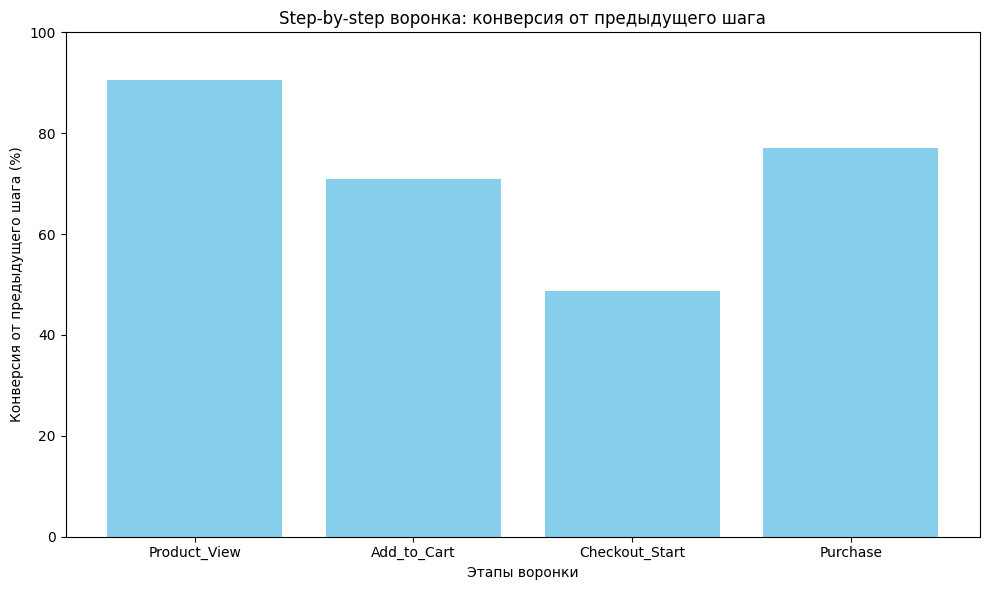

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загружаем данные
df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_4_3_4_retail_user_data.csv')

# Задаём порядок шагов в воронке
funnel_steps = ['Visit', 'Product_View', 'Add_to_Cart', 'Checkout_Start', 'Purchase']

# Фильтруем датасет, оставляя только нужные шаги воронки
funnel_df_steps = df[df['event_name'].isin(funnel_steps)]

# Считаем число уникальных пользователей на каждом шаге
funnel_counts = funnel_df_steps.groupby('event_name')['user_id'].nunique().reindex(funnel_steps)

# Собираем таблицу воронки
funnel_df = pd.DataFrame({
    'step': funnel_steps,
    'users': funnel_counts.values
})

# Добавляем конверсии
funnel_df['conversion_from_first_%'] = (funnel_df['users'] / funnel_df['users'].iloc[0] * 100).round(1)
funnel_df['conversion_from_previous_%'] = (funnel_df['users'] / funnel_df['users'].shift(1) * 100).round(1)

# Визуализируем step-by-step воронку начиная со второго шага
plt.figure(figsize=(10, 6))
plt.bar(
    funnel_df['step'][1:],  # шаги, начиная с Product_View
    funnel_df['conversion_from_previous_%'][1:],  # соответствующие значения
    color='skyblue'
)

plt.title('Step-by-step воронка: конверсия от предыдущего шага')
plt.ylabel('Конверсия от предыдущего шага (%)')
plt.xlabel('Этапы воронки')
plt.ylim(0, 100)  # по желанию — ограничиваем ось Y для визуальной читаемости
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Загружаем данные
df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_4_3_4_retail_user_data.csv')

# Шаги воронки
funnel_steps = ['Visit', 'Product_View', 'Add_to_Cart', 'Checkout_Start', 'Purchase']

# Разделим данные по платформам
mobile_df = df[df['platform'] == 'mobile']
desktop_df = df[df['platform'] == 'desktop']

# === Десктоп ===
# Фильтруем события
counts_desktop = desktop_df[desktop_df['event_name'].isin(funnel_steps)]
# Считаем уникальных пользователей по шагам
counts_desktop_agg = counts_desktop.groupby('event_name')['user_id'].nunique().reindex(funnel_steps)
# Строим step-by-step воронку
desktop_funnel = (counts_desktop_agg / counts_desktop_agg.shift(1) * 100).round(1)

# === Мобильные ===
counts_mobile = mobile_df[mobile_df['event_name'].isin(funnel_steps)]
counts_mobile_agg = counts_mobile.groupby('event_name')['user_id'].nunique().reindex(funnel_steps)
mobile_funnel = (counts_mobile_agg / counts_mobile_agg.shift(1) * 100).round(1)

# Финальная таблица — сравнение
funnel_compare = pd.DataFrame({
    'step': funnel_steps[1:],  # начиная со второго шага
    'mobile': mobile_funnel[funnel_steps[1:]].values,
    'desktop': desktop_funnel[funnel_steps[1:]].values
})

# Выводим результат
print(funnel_compare.head(5))


             step  mobile  desktop
0    Product_View    92.6     88.8
1     Add_to_Cart    71.0     70.7
2  Checkout_Start    41.5     55.9
3        Purchase    75.0     78.5


In [ ]:
import pandas as pd

# Загружаем данные с приведением времени к datetime
df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_4_3_4_retail_user_data.csv', parse_dates=['event_time'])

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Шаги воронки
steps = ['Visit', 'Product_View', 'Add_to_Cart', 'Checkout_Start', 'Purchase']

# Получаем списки пользователей по платформам
mobile_ids = df[df['platform'] == 'mobile']['user_id'].unique()
desktop_ids = df[df['platform'] == 'desktop']['user_id'].unique()

# Словари для хранения медианных времён
deltas_mobile = {}
deltas_desktop = {}

# Цикл по парам шагов воронки
for i in range(1, len(steps)):
    step1 = steps[i - 1]
    step2 = steps[i]

    # --- Для mobile ---
    t1_mobile = df[df['event_name'] == step1][['user_id', 'event_time']]
    t2_mobile = df[df['event_name'] == step2][['user_id', 'event_time']]
    t1_mobile = t1_mobile[t1_mobile['user_id'].isin(mobile_ids)]
    t2_mobile = t2_mobile[t2_mobile['user_id'].isin(mobile_ids)]

    # Объединяем по user_id
    t_mobile = pd.merge(t1_mobile, t2_mobile, on='user_id', suffixes=('_start', '_end'))
    delta_mobile = (t_mobile['event_time_end'] - t_mobile['event_time_start']).dt.total_seconds()
    deltas_mobile[f'{step1} to {step2}'] = round(delta_mobile.median(), 1)

    # --- Для desktop ---
    t1_desktop = df[df['event_name'] == step1][['user_id', 'event_time']]
    t2_desktop = df[df['event_name'] == step2][['user_id', 'event_time']]
    t1_desktop = t1_desktop[t1_desktop['user_id'].isin(desktop_ids)]
    t2_desktop = t2_desktop[t2_desktop['user_id'].isin(desktop_ids)]

    t_desktop = pd.merge(t1_desktop, t2_desktop, on='user_id', suffixes=('_start', '_end'))
    delta_desktop = (t_desktop['event_time_end'] - t_desktop['event_time_start']).dt.total_seconds()
    deltas_desktop[f'{step1} to {step2}'] = round(delta_desktop.median(), 1)

# Собираем таблицу сравнения
comparison_df = pd.DataFrame({
    'step': list(deltas_mobile.keys()),
    'mobile_users_median_sec': list(deltas_mobile.values()),
    'desktop_users_median_sec': list(deltas_desktop.values())
})

# Выводим результат
print(comparison_df.head())


                            step  mobile_users_median_sec  desktop_users_median_sec
0          Visit to Product_View                    157.5                     158.0
1    Product_View to Add_to_Cart                    306.0                     314.0
2  Add_to_Cart to Checkout_Start                    354.0                     305.0
3     Checkout_Start to Purchase                    176.0                     163.0


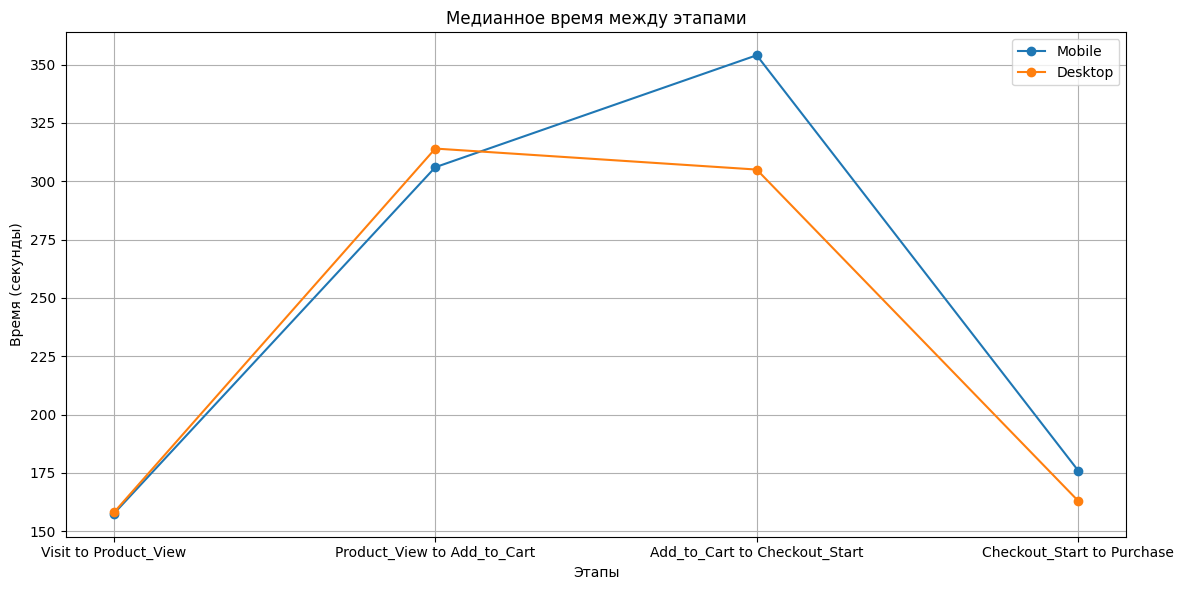

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загружаем финальный датасет
comparison_df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_4_3_4_comparison_df.csv')

plt.figure(figsize=(12, 6))

# Строим linechart для mobile_users_median_sec по шагам
plt.plot(comparison_df['step'], comparison_df['mobile_users_median_sec'], marker='o', label='Mobile')

# Строим linechart для desktop_users_median_sec по шагам
plt.plot(comparison_df['step'], comparison_df['desktop_users_median_sec'], marker='o', label='Desktop')

# Добавляем оформление
plt.title('Медианное время между этапами')
plt.xlabel('Этапы')
plt.ylabel('Время (секунды)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
